<a href="https://colab.research.google.com/github/edwardoughton/UK_Fixed_Broadband_Availability/blob/master/scenario_modeling_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mapclassify --upgrade
!pip install contextily

In [ ]:
# !cp -r /content/drive/MyDrive/spwio/data .
# !tar -cvzf data.rar data

# !cp data.rar /content/drive/MyDrive/spwio/data

# Download data
!wget -O data.rar https://zenodo.org/records/10586809/files/data.rar?download=1

!tar -xvzf data.rar

--2024-01-30 13:55:51--  https://zenodo.org/records/10586809/files/data.rar?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1156013605 (1.1G) [application/octet-stream]
Saving to: ‘data.rar’

data.rar            100%[===================>]   1.08G  23.7MB/s    in 48s     

2024-01-30 13:56:41 (22.8 MB/s) - ‘data.rar’ saved [1156013605/1156013605]

data/
data/ZIPCodetoZCTACrosswalk2021UDS.xlsx
data/results/
data/results/supply/
data/pop_perc.csv
data/zbp21totals.txt
data/data.rar
data/NAICS_EST_GDP2022_ZCTA.csv
data/zbp21detail.zip
data/nerc_gdf.geojson
data/GDP_shocks_est.csv
data/IOdata/
data/IOdata/SpaceWeatherIO2.Rmd
data/IOdata/pop_perc.csv
data/IOdata/IndByComs.csv
data/IOdata/pop_est.csv
data/IOdata/tech_coeff_1.csv
data/IOdata/gdp_loss_est.csv
data/IOdata/GDP_shocks_est.csv
data/IOdata/GDPshock.csv
data

In [ ]:
import random
import os
import glob
import json
import warnings
import csv
import tqdm
import time
import shutil
import string
import math
import gc
import json
from itertools import combinations, product, islice

import pandas as pd
import numpy as np
from multiprocessing import Pool, Lock, cpu_count
from concurrent.futures import ThreadPoolExecutor
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import geopandas as gpd
# import contextily as ctx

# prompt: suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
# # configure data path
# current_path = os.path.dirname(os.path.abspath("__file__"))
# data_path = os.path.join(current_path, "..", "data")

# data_path = os.path.normpath(data_path)

working_dir = "/content"
data_path = os.path.join(working_dir, "data")

In [ ]:
# map op naics industries

# NAICs Industries
NAICSIndustries = {
    "11": "Agriculture, Forestry, Fishing and Hunting",
    "21": "Mining, Quarrying, and Oil and Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31": "Manufacturing",
    "42": "Wholesale Trade",
    "44": "Retail Trade",
    "48": "Transportation and Warehousing",
    "51": "Information",
    "52": "Finance and Insurance",
    "53": "Real Estate and Rental and Leasing",
    "54": "Professional, Scientific, and Technical Services",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative and Support and Waste ...",
    "61": "Educational Services",
    "62": "Health Care and Social Assistance",
    "71": "Arts, Entertainment, and Recreation",
    "72": "Accommodation and Food Services",
    "81": "Other Services (except Public Administration)",
    "UNCLFD": "Unclassified",
}

In [ ]:
# read the business and economic data at zcta and state levels
data_zcta_path = os.path.join(data_path, "NAICS_EST_GDP2022_ZCTA.csv")
population_df_path = os.path.join(data_path, "2020_decennial_census_at_ZCTA_level.csv")

# Reading data
data_zcta = pd.read_csv(data_zcta_path)
population_df = pd.read_csv(population_df_path)

# Merging and aggregating data
unique_zcta_regions = data_zcta[["ZCTA", "REGIONS", "STABBR"]].drop_duplicates()
regions_pop_df = unique_zcta_regions.merge(population_df, on=["ZCTA", "STABBR"])
total_pop_regions = regions_pop_df.groupby("REGIONS")["POP20"].sum().reset_index()

sum_total_pop = total_pop_regions.POP20.sum()
total_pop_regions["POP20Ratio"] = total_pop_regions.POP20 / sum_total_pop
total_pop_regions = total_pop_regions[total_pop_regions.REGIONS != "NotOrder1000"]

# import the grid regions
ferc_gdf = gpd.read_file(os.path.join(data_path, "nerc_gdf.geojson"))

In [ ]:
total_pop_regions.REGIONS.unique()

array(['CAISO', 'ERCOT', 'FRCC', 'ISONE', 'MISO', 'NYISO',
       'NorthernGridConnected', 'NorthernGridUnconnected', 'PJM', 'SCRTP',
       'SERTP', 'SPP', 'WestConnect', 'WestConnectNonEnrolled'],
      dtype=object)

### Business counts and GDP contribution by NAICs Classification
In our calculation, we assume uniform every person/business contribute equally to State GDP.

In [ ]:
# zcta
df_business = (
    data_zcta.groupby(["REGIONS", "NAICS"])[["EST", "GDP2022"]].sum().reset_index()
)

df_business.GDP2022 = df_business.GDP2022 / 1000
sum_total_gdp = df_business.GDP2022.sum() * 1 / 365

total_est_by_naics = df_business.groupby("NAICS")["EST"].sum().sum()

df_business["DailyGDP"] = df_business.GDP2022.map(lambda x: (x / 365))
df_business["ESTPerc"] = df_business.apply(
    lambda row: row["EST"] / total_est_by_naics, axis=1
)

# Exclude Non-order 1000 region
df_business = df_business[df_business.REGIONS != "NotOrder1000"]
df_business.head(5)

,REGIONS,NAICS,EST,GDP2022,DailyGDP,ESTPerc
0,CAISO,11,1254.0,26.55421,0.072751,0.000157
1,CAISO,21,257.0,6.40774,0.017555,0.000032
2,CAISO,22,552.0,36.87954,0.101040,0.000069
3,CAISO,23,75608.0,99.96392,0.273874,0.009465
4,CAISO,31,33696.0,335.19854,0.918352,0.004218


In [ ]:
# Export the business data as a dictionary
nested_dict = {}
region_pop = total_pop_regions.set_index("REGIONS")[["POP20", "POP20Ratio"]]

for _, row in df_business.iterrows():
    region = row["REGIONS"]
    naics = row["NAICS"]

    if region not in nested_dict:
        nested_dict[region] = {
            "NAICS": {},
            "POP20": region_pop.loc[region]["POP20"],
            "POP20Ratio": region_pop.loc[region]["POP20Ratio"],
        }

    nested_dict[region]["NAICS"][naics] = {
        "EST": row["EST"],
        "ESTPerc": row["ESTPerc"],
        "DAILYGDP": row["DailyGDP"],
    }

## Estimates of the number of businesses and population without power

In [ ]:
# Regions and their possible states (0 or 1)
# states denote all regions with or without power
regions = df_business.REGIONS.unique()

# 0 with power in the entire block, 1 without power
states = [0, 1]

# Generate all possible combinations
combinations = list(product(states, repeat=len(regions)))
df_combinations = pd.DataFrame(combinations, columns=list(df_business.REGIONS.unique()))
df_combinations

,CAISO,ERCOT,FRCC,ISONE,MISO,NYISO,NorthernGridConnected,NorthernGridUnconnected,PJM,SCRTP,SERTP,SPP,WestConnect,WestConnectNonEnrolled
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16379,1,1,1,1,1,1,1,1,1,1,1,0,1,1
16380,1,1,1,1,1,1,1,1,1,1,1,1,0,0
16381,1,1,1,1,1,1,1,1,1,1,1,1,0,1
16382,1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [ ]:
df_bus_sum = (
    df_business.groupby("REGIONS")[["EST", "DailyGDP", "ESTPerc"]].sum().reset_index()
)
df_bus_po = df_bus_sum.merge(total_pop_regions, on="REGIONS")
df_bus_po["DailyGDPPerc"] = df_bus_po["DailyGDP"] / sum_total_gdp
df_index = df_bus_po.set_index("REGIONS")

#  save the grid regions quant figures
df_index.to_csv(os.path.join(data_path, "grid_data.csv"))

In [ ]:
# Save the grid data
df_index.to_json(os.path.join(data_path, "grid_data.json"))

In [ ]:
# transpose the business df and cast on the combinatioons df
transposed_df = df_index.T
transposed_df

REGIONS,CAISO,ERCOT,FRCC,ISONE,MISO,NYISO,NorthernGridConnected,NorthernGridUnconnected,PJM,SCRTP,SERTP,SPP,WestConnect,WestConnectNonEnrolled
EST,9.302580e+05,5.713920e+05,5.847680e+05,3.663680e+05,1.051459e+06,5.859790e+05,4.633720e+05,1.114560e+05,1.550176e+06,6.614400e+04,8.915730e+05,3.596550e+05,2.398830e+05,1.647360e+05
DailyGDP,8.322560e+00,4.735475e+00,3.196764e+00,2.912896e+00,7.118827e+00,5.261589e+00,3.180750e+00,8.352190e-01,1.179109e+01,3.845126e-01,6.132122e+00,2.335112e+00,1.633155e+00,1.101187e+00
ESTPerc,1.164573e-01,7.153152e-02,7.320604e-02,4.586494e-02,1.316302e-01,7.335764e-02,5.800869e-02,1.395297e-02,1.940637e-01,8.280447e-03,1.116144e-01,4.502455e-02,3.003051e-02,2.062300e-02
POP20,3.666968e+07,2.575638e+07,2.026976e+07,1.416044e+07,4.465623e+07,2.199486e+07,1.609561e+07,4.593872e+06,6.574212e+07,2.695532e+06,3.995916e+07,1.434230e+07,9.947333e+06,6.191785e+06
POP20Ratio,1.126283e-01,7.910886e-02,6.225710e-02,4.349276e-02,1.371584e-01,6.755562e-02,4.943651e-02,1.410975e-02,2.019222e-01,8.279131e-03,1.227317e-01,4.405134e-02,3.055251e-02,1.901762e-02
DailyGDPPerc,1.402378e-01,7.979429e-02,5.386652e-02,4.908325e-02,1.199545e-01,8.865949e-02,5.359667e-02,1.407371e-02,1.986837e-01,6.479161e-03,1.033282e-01,3.934740e-02,2.751919e-02,1.855537e-02


The business dataframe consist of total number of the employed, establishments, and population in grid regions

In [ ]:
# broadcast the emp, population, and establishment on the combination df
array_transposed = transposed_df.to_numpy()
array_comb = df_combinations.to_numpy()

result_array = array_transposed[:, np.newaxis, :] * array_comb

In [ ]:
scenario_dfs = []

daily_gdp_df = transposed_df[transposed_df.index == "DailyGDP"]

for i in range(1, len(regions)):

  daily_gdp_array = daily_gdp_df.to_numpy()

  df_filtered = df_combinations.loc[df_combinations.iloc[:, :].sum(axis=1) == i]
  df_filtered_array = df_filtered.to_numpy()

  df_filtered_result = pd.DataFrame(daily_gdp_array * df_filtered_array, columns=list(regions))

  df_filtered_result["GDPSum"] = df_filtered_result.sum(axis=1)
  df_filtered_result = df_filtered_result.sort_values(by="GDPSum", ascending=True)
  scenario_dfs.append(df_filtered_result)



3.1887572602739724

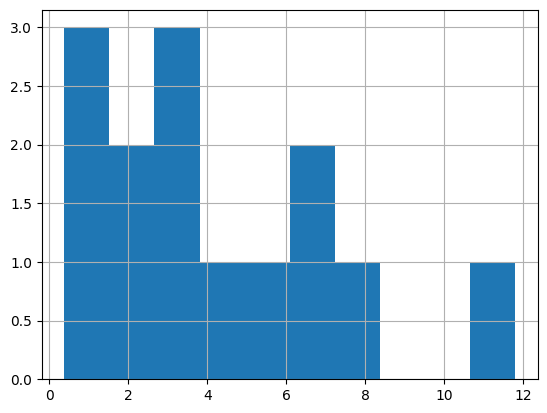

In [ ]:
# Scenarios where a single grid region is out of power

# Est without power
scenario_dfs[0]["GDPSum"].hist()

scenario_dfs[0]["GDPSum"].quantile(0.5)

In [ ]:
# Combinations stats

gdp_means = []
gdp_variances = []
num_combinations = []

# Iterate over each scenario dataframe
for scenario_df in scenario_dfs:
    # Calculate the average GDP for the current scenario
    gdp_means.append(scenario_df['GDPSum'].mean())

    # Calculate the variance of GDP for the current scenario
    gdp_variances.append(scenario_df['GDPSum'].var())

    # Count the number of combinations (rows) in the current scenario
    num_combinations.append(len(scenario_df))

# Create a DataFrame to hold the results
scenario_stats_df = pd.DataFrame({
    'Scenario': np.arange(1, len(scenario_dfs) + 1),
    'Average_GDP': gdp_means,
    'GDP_Variance': gdp_variances,
    'Number_of_Combinations': num_combinations
})

# Display the DataFrame
print(scenario_stats_df)

    Scenario  Average_GDP  GDP_Variance  Number_of_Combinations
0          1     4.210090     10.579685                      14
1          2     8.420180     18.338120                      91
2          3    12.630270     25.006527                     364
3          4    16.840360     30.257898                    1001
4          5    21.050450     34.023124                    2002
5          6    25.260540     36.285288                    3003
6          7    29.470630     37.039689                    3432
7          8    33.680720     36.285288                    3003
8          9    37.890810     34.023124                    2002
9         10    42.100900     30.257898                    1001
10        11    46.310991     25.006527                     364
11        12    50.521081     18.338120                      91
12        13    54.731171     10.579685                      14


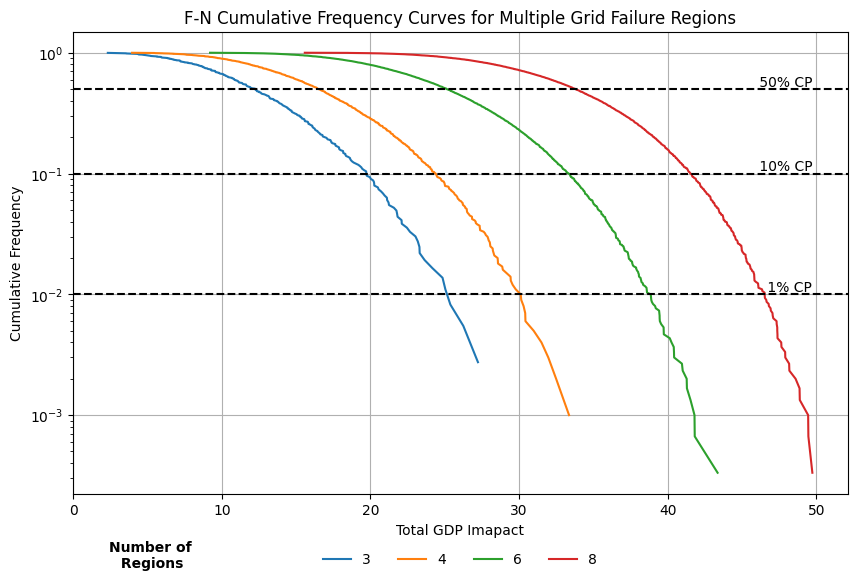

In [ ]:
plt.figure(figsize=(10, 6))

# Define the quantiles
quantiles = [0.01, 0.1, 0.5]
quantile_labels = ['1%', '10%', '50%']

# Grid Failures
grid_failures = [3, 4, 6, 8] # 3, 4, or 6 regions fail

# Loop over each DataFrame in scenario_dfs
for i in grid_failures:

    df_scenario = scenario_dfs[i-1]

    # Rank the data
    df_scenario['Rank'] = df_scenario['GDPSum'].rank(ascending=False)

    # Calculate cumulative frequency 'Fi'
    n = len(df_scenario)
    df_scenario['Fi'] = df_scenario['Rank'] / (n + 1)

    # Sort by 'GDPSum' for plotting
    df_scenario = df_scenario.sort_values('GDPSum', ascending=True)

    # Plot the cumulative frequency curve
    plt.plot(df_scenario['GDPSum'], df_scenario['Fi'], linestyle='-', label=f'{i}')

# Set the y-axis to log scale
plt.yscale('log')

# Add horizontal lines for each quantile value of Fi and label them
for value, label in zip(quantiles, quantile_labels):
  plt.axhline(y=value, color='k', linestyle='--')
  plt.text(x=max(df_scenario['GDPSum']), y=value, s=f' {label} CP', color='k', va='bottom', ha='right')

# Add labels and title
plt.xlabel('Total GDP Imapact')
plt.ylabel('Cumulative Frequency')
plt.title('F-N Cumulative Frequency Curves for Multiple Grid Failure Regions')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False)

# Add a text object to act as a legend title
plt.text(x=0.1, y=-0.1, s='Number of\n Regions', ha='center', va='top', transform=plt.gca().transAxes,  weight='bold')
plt.grid(True)
plt.show()

In [ ]:
scenario_percentile_dfs = []

for i in grid_failures:

    df_scenario = scenario_dfs[i-1]

    # Calculate Fi rank
    df_scenario['Fi'] = df_scenario['GDPSum'].rank(ascending=False) / len(df_scenario)
    df_scenario_sorted = df_scenario.sort_values('Fi', ascending=False)

    # List to hold rows for the current scenario
    percentile_rows = []

    for percentile in quantiles:
        # Calculate the row corresponding to the percentile based on Fi
        value = df_scenario_sorted['Fi'].quantile(percentile)
        # Get the row with the Fi value closest to the calculated percentile value
        row = df_scenario_sorted.iloc[(df_scenario_sorted['Fi']-value).abs().argsort()[:1]]
        # row["Probability"] = percentile
        percentile_rows.append(row)

    scenario_percentile_df = pd.concat(percentile_rows)
    # Drop the Fi and Rank
    scenario_percentile_df.drop(["Rank", "Fi"], axis=1, inplace=True)
    # scenario_percentile_df["Size"] = i
    scenario_percentile_dfs.append(scenario_percentile_df)

In [ ]:

def get_transformed_data(df, quantiles=quantiles, nested_dict=nested_dict, df_index=df_index):
    """
    Transforms the input DataFrame and calculates various metrics for GDP and establishments.

    Parameters:
    df (DataFrame): The input DataFrame.
    quantiles (list): List of quantile values.
    nested_dict (dict): Nested dictionary containing NAICS data.
    df_index (DataFrame): DataFrame containing index data such as DailyGDP and POP20.

    Returns:
    tuple: A dictionary containing grouped region and NAICS data, and population data.
    """
    # Transpose and rename columns
    percentiles_transformed = df.T
    percentiles_transformed.columns = quantiles
    percentiles_transformed.drop("GDPSum", inplace=True)

    # Initialize data lists
    new_rows_gdp, new_rows_est = [], []
    col_names = [f"perc{int(i*100)}" if i != 0 else "perc0" for i in quantiles]
    new_col_names = ["REGIONS", "NAICS"] + col_names

    # Process each region
    for reg, row in percentiles_transformed.iterrows():
        non_zero_indices = [i for i, value in enumerate(row) if value != 0]

        for naics, data in nested_dict[reg]["NAICS"].items():
            new_row_gdp = [reg, naics] + [data["DAILYGDP"] if i in non_zero_indices else 0 for i in range(len(row))]
            new_row_est = [reg, naics] + [data["EST"] if i in non_zero_indices else 0 for i in range(len(row))]

            new_rows_gdp.append(new_row_gdp)
            new_rows_est.append(new_row_est)

    # Create DataFrames
    df_gdp = pd.DataFrame(new_rows_gdp, columns=new_col_names)
    df_est = pd.DataFrame(new_rows_est, columns=new_col_names)

    # Group by regions and NAICS
    grouped_regions_est = df_est.groupby("REGIONS").sum()
    grouped_naics_est = df_est.groupby("NAICS").sum()
    df_gdp_naics = df_gdp.groupby("NAICS").sum()
    df_gdp_regions = df_gdp.groupby("REGIONS").sum()

    # Calculate percentages of daily output
    gdp_loss_est_df_perc = (df_gdp_naics / df_index.DailyGDP.sum()).round(2)

    # Establishments without power
    est_binary = grouped_regions_est.ne(0).astype(int)

    # Population without power
    pop_est_df = (est_binary.apply(lambda row: row * df_index.loc[row.name, "POP20"], axis=1) / 1000000).round(2)
    pop_est_df_perc = (pop_est_df / (df_index.POP20.sum()/1e6)).round(2)

    return {"regions_est": grouped_regions_est, "gdp_by_naics": df_gdp_naics, "gdp_by_regions": df_gdp_regions, "pop": pop_est_df }


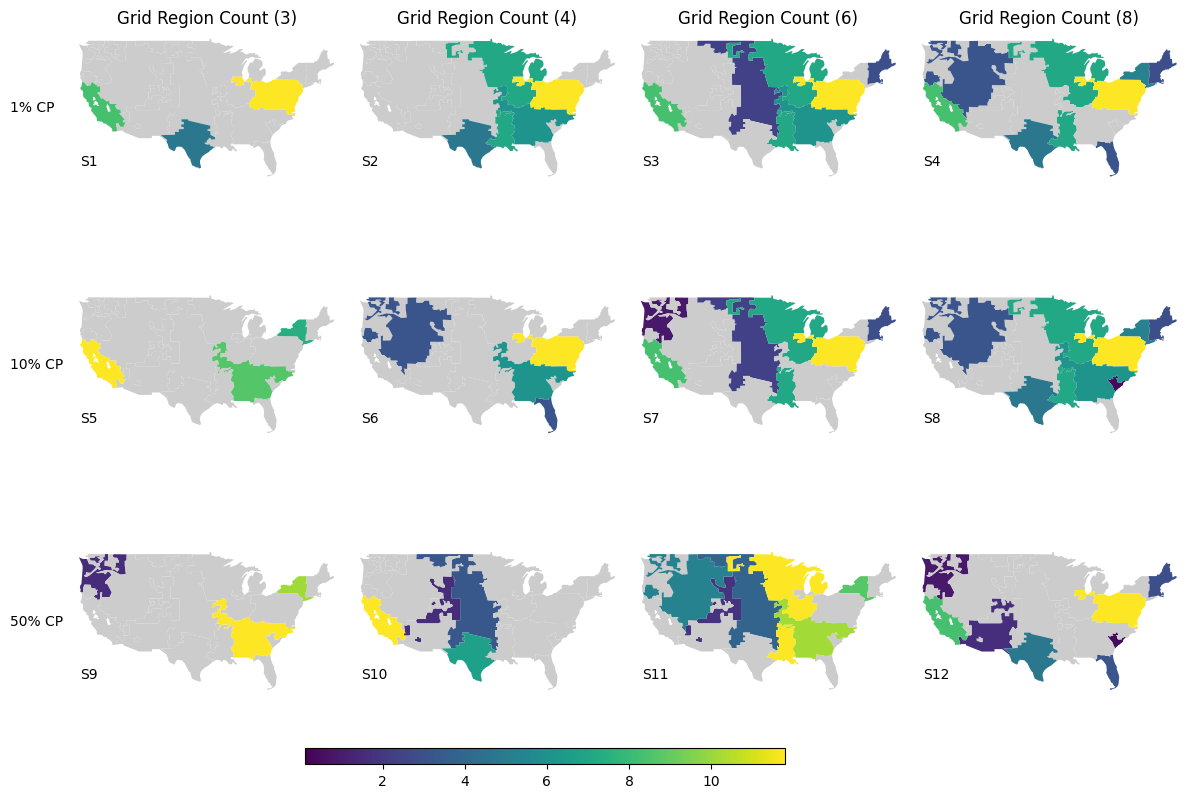

In [ ]:
us_crs = 'epsg:4269'
ncols = len(scenario_percentile_dfs)
nrows = len(quantiles)

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows, ncols, hspace=0, wspace=0)

axes = []
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

cmap = plt.cm.viridis
cmap.set_under('#cccccc')

for k, ax in enumerate(axes):
    i = k // ncols
    j = k % ncols

    scenario_df = scenario_percentile_dfs[j]
    quantile = quantiles[i]

    # Transform data for the current scenario
    data = get_transformed_data(scenario_df)
    merged_gdf = ferc_gdf.merge(data["gdp_by_regions"], on="REGIONS")

    gdf_copy = merged_gdf.copy()
    perc_column = f"perc{int(quantile*100)}"
    gdf_copy = gdf_copy.dropna(subset=[perc_column])

    # Plot each regionpop
    gdf_copy.to_crs(us_crs).plot(
        perc_column,
        cmap=cmap,
        ax=ax,
        vmin=0.1
    )

    # Add scenario label on the bottom left of each subplot
    ax.text(0.05, 0.1, f'S{k + 1}', transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='left')

    # Add percentile label on the left of the first column
    if j == 0:
        ax.text(-0.2, 0.5, f'{int(quantile * 100)}% CP', transform=ax.transAxes, fontsize=10, va='center')

    # Add grid failure label on the top center of the first row
    if i == 0:
        ax.set_title(f"Grid Region Count ({grid_failures[j]})", loc='center')

    ax.set_facecolor('grey')
    ax.axis("off")

# Create a common colorbar
norm = colors.Normalize(vmin=0.1, vmax=gdf_copy[perc_column].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.25, 0.0, 0.4, 0.02])
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.show()

## Indirect Impact Models

In [ ]:
# Read CSV files
TechnicalCoefficients = pd.read_csv(os.path.join(data_path, "IOdata", "IndByComs.csv"))
grossOutput2022 = pd.read_csv(os.path.join(data_path, "IOdata", "output_2022.csv")).iloc[:, 1] / 1000
consumption = pd.read_csv(os.path.join(data_path, "IOdata", "consumption.csv")).iloc[:, 2] / (365 * 1.2)

Industries = pd.read_csv(os.path.join(data_path, "IOdata", "Gross.csv")).iloc[:, 0]
Industries.iloc[68] = "State Government Enterprises"

# Leontief matrix calculation
L = TechnicalCoefficients.to_numpy()
Identity = np.eye(69)
A = Identity - np.linalg.inv(L)
GrossDiag = np.diag(grossOutput2022)
GrossDiagInv = np.linalg.inv(GrossDiag)
BMatrix = np.dot(np.dot(GrossDiagInv, A), GrossDiag)

# Ghosh model calculation
Ghosh = np.linalg.inv(Identity - BMatrix)

# Read GDP shocks and population scenario data
GDPShocks = pd.read_csv(os.path.join(data_path, "IOdata", "GDP_shocks_est.csv"))
pop_scenario = pd.read_csv(os.path.join(data_path, "IOdata", "pop_est.csv"))

# Grid data calculations
grid_data = pd.read_csv(os.path.join(data_path, "IOdata", "grid_data.csv"))
total_pop = grid_data['POP20'].sum() / 1e6  # total population in millions
daily_gdp = grid_data["DailyGDP"].sum()

In [ ]:
# expand and compress the shocks using 2022 gross output values
def get_value_added(GDPShocks, i):

    # Give a second tier NAICS shocks
    VA = np.zeros(69)  # Initialize VA with zeros

    # NAICS 11 - Farms
    VA[0] = GDPShocks.iloc[0, i + 1] * 0.887
    VA[1] = GDPShocks.iloc[0, i + 1] * 0.113

    # NAICS 21 - Oil and Gas
    VA[2] = GDPShocks.iloc[1, i + 1] * 0.725
    VA[3] = GDPShocks.iloc[1, i + 1] * 0.173
    VA[4] = GDPShocks.iloc[1, i + 1] * 0.102

    # NAICS 22
    VA[5] = GDPShocks.iloc[2, i + 1]

    # NAICS 23
    VA[6] = GDPShocks.iloc[3, i + 1]

    # NAICS 31
    NAICS_31_multipliers = [0.0238, 0.0232, 0.0415, 0.0623, 0.0656, 0.0637, 0.0228,
                            0.1160, 0.0487, 0.0126, 0.0289, 0.1667, 0.0083, 0.0036,
                            0.0304, 0.0125, 0.0962, 0.1341, 0.0391]

    for idx, multiplier in enumerate(NAICS_31_multipliers):
        VA[7 + idx] = GDPShocks.iloc[4, i + 1] * multiplier

    # NAICS 42
    VA[26] = GDPShocks.iloc[5, i + 1]

    # NAICS 44
    VA[27] = GDPShocks.iloc[6, i + 1] * 0.1570
    VA[28] = GDPShocks.iloc[6, i + 1] * 0.1270
    VA[29] = GDPShocks.iloc[6, i + 1] * 0.1205
    VA[30] = GDPShocks.iloc[6, i + 1] * 0.5956

    # NAICS 48
    VA[31] = GDPShocks.iloc[7, i + 1] * 0.1488
    VA[32] = GDPShocks.iloc[7, i + 1] * 0.0549
    VA[33] = GDPShocks.iloc[7, i + 1] * 0.0350
    VA[34] = GDPShocks.iloc[7, i + 1] * 0.3224
    VA[35] = GDPShocks.iloc[7, i + 1] * 0.0484
    VA[36] = GDPShocks.iloc[7, i + 1] * 0.0403
    VA[37] = GDPShocks.iloc[7, i + 1] * 0.2289
    VA[38] = GDPShocks.iloc[7, i + 1] * 0.1213

    # NAICS 51
    VA[39] = GDPShocks.iloc[8, i + 1] * 0.2211
    VA[40] = GDPShocks.iloc[8, i + 1] * 0.0757
    VA[41] = GDPShocks.iloc[8, i + 1] * 0.4139
    VA[42] = GDPShocks.iloc[8, i + 1] * 0.2904

    # NAICS 52
    VA[43] = GDPShocks.iloc[9, i + 1] * 0.3105
    VA[44] = GDPShocks.iloc[9, i + 1] * 0.2282
    VA[45] = GDPShocks.iloc[9, i + 1] * 0.4056
    VA[46] = GDPShocks.iloc[9, i + 1] * 0.0557

    # NAICS 53
    VA[47] = GDPShocks.iloc[10, i + 1] * 0.7963
    VA[48] = GDPShocks.iloc[10, i + 1] * 0.2037

    # NAICS 54
    VA[49] = GDPShocks.iloc[11, i + 1] * 0.1480
    VA[50] = GDPShocks.iloc[11, i + 1] * 0.1936
    VA[51] = GDPShocks.iloc[11, i + 1] * 0.6584

    # NAICS 55
    VA[52] = GDPShocks.iloc[12, i + 1]

    # NAICS 56
    VA[53] = GDPShocks.iloc[13, i + 1] * 0.9073
    VA[54] = GDPShocks.iloc[13, i + 1] * 0.0927

    # NAICS 61
    VA[55] = GDPShocks.iloc[14, i + 1]

    # NAICS 62
    VA[56] = GDPShocks.iloc[15, i + 1] * 0.4396
    VA[57] = GDPShocks.iloc[15, i + 1] * 0.3722
    VA[58] = GDPShocks.iloc[15, i + 1] * 0.0949
    VA[59] = GDPShocks.iloc[15, i + 1] * 0.0934

    # NAICS 71
    VA[60] = GDPShocks.iloc[16, i + 1] * 0.5709
    VA[61] = GDPShocks.iloc[16, i + 1] * 0.4291

    # NAICS 72
    VA[62] = GDPShocks.iloc[17, i + 1] * 0.2011
    VA[63] = GDPShocks.iloc[17, i + 1] * 0.7989

    # NAICS 81
    VA[64] = GDPShocks.iloc[18, i + 1] * 0.2011

    # NAICS UNCLFD
    VA[65] = GDPShocks.iloc[19, i + 1] * 0.1537
    VA[66] = GDPShocks.iloc[19, i + 1] * 0.0248
    VA[67] = GDPShocks.iloc[19, i + 1] * 0.7197
    VA[68] = GDPShocks.iloc[19, i + 1] * 0.1017

    return VA


def condense_output(Output, LeonOutput):

    # Initialize arrays for condensed output
  CondensedOutput = np.zeros(20)
  CondensedLeonOutput = np.zeros(20)

  # Aggregate values by NAICS codes
  # NAICS 11 - Farms
  CondensedOutput[0] = Output[[0, 1]].sum()
  CondensedLeonOutput[0] = LeonOutput[[0, 1]].sum()

  # NAICS 21 - Mining, Quarrying, and Oil and Gas Extraction
  CondensedOutput[1] = Output[[2, 3, 4]].sum()
  CondensedLeonOutput[1] = LeonOutput[[2, 3, 4]].sum()

  # NAICS 22 - Utilities
  CondensedOutput[2] = Output[5].sum()
  CondensedLeonOutput[2] = LeonOutput[5].sum()

  # NAICS 23 - Construction
  CondensedOutput[3] = Output[6].sum()
  CondensedLeonOutput[3] = LeonOutput[6].sum()

  # NAICS 31-33 - Manufacturing
  CondensedOutput[4] = Output[7:26].sum()
  CondensedLeonOutput[4] = LeonOutput[7:26].sum()

  # NAICS 42 - Wholesale Trade
  CondensedOutput[5] = Output[26].sum()
  CondensedLeonOutput[5] = LeonOutput[26].sum()

  # NAICS 44-45 - Retail Trade
  CondensedOutput[6] = Output[27:31].sum()
  CondensedLeonOutput[6] = LeonOutput[27:31].sum()

  # NAICS 48-49 - Transportation and Warehousing
  CondensedOutput[7] = Output[31:39].sum()
  CondensedLeonOutput[7] = LeonOutput[31:39].sum()

  # NAICS 51 - Information
  CondensedOutput[8] = Output[39:43].sum()
  CondensedLeonOutput[8] = LeonOutput[39:43].sum()

  # NAICS 52 - Finance and Insurance
  CondensedOutput[9] = Output[43:47].sum()
  CondensedLeonOutput[9] = LeonOutput[43:47].sum()

  # NAICS 53 - Real Estate and Rental and Leasing
  CondensedOutput[10] = Output[[47, 48]].sum()
  CondensedLeonOutput[10] = LeonOutput[[47, 48]].sum()

  # NAICS 54 - Professional, Scientific, and Technical Services
  CondensedOutput[11] = Output[49:52].sum()
  CondensedLeonOutput[11] = LeonOutput[49:52].sum()

  # NAICS 55 - Management of Companies and Enterprises
  CondensedOutput[12] = Output[52].sum()
  CondensedLeonOutput[12] = LeonOutput[52].sum()

  # NAICS 56 - Administrative and Support and Waste Management and Remediation Services
  CondensedOutput[13] = Output[[53, 54]].sum()
  CondensedLeonOutput[13] = LeonOutput[[53, 54]].sum()

  # NAICS 61 - Educational Services
  CondensedOutput[14] = Output[55].sum()
  CondensedLeonOutput[14] = LeonOutput[55].sum()

  # NAICS 62 - Health Care and Social Assistance
  CondensedOutput[15] = Output[56:60].sum()
  CondensedLeonOutput[15] = LeonOutput[56:60].sum()

  # NAICS 71 - Arts, Entertainment, and Recreation
  CondensedOutput[16] = Output[[60, 61]].sum()
  CondensedLeonOutput[16] = LeonOutput[[60, 61]].sum()

  # NAICS 72 - Accommodation and Food Services
  CondensedOutput[17] = Output[[62, 63]].sum()
  CondensedLeonOutput[17] = LeonOutput[[62, 63]].sum()

  # NAICS 81 - Other Services (except Public Administration)
  CondensedOutput[18] = Output[64].sum()
  CondensedLeonOutput[18] = LeonOutput[64].sum()

  # NAICS UNCLFD - Unclassified
  CondensedOutput[19] = Output[65:69].sum()
  CondensedLeonOutput[19] = LeonOutput[65:69].sum()

  return CondensedOutput, CondensedLeonOutput

In [ ]:
# Run Ghosh model to get indirect supply impacts

impact_dfs = []
percentile = 100
scenario_counter = 0  # Scenario counter

for i, scenario_df in tqdm.tqdm(enumerate(scenario_percentile_dfs)):
    extent = grid_failures[i]

    soc_econ_df = get_transformed_data(scenario_df)
    GDPShocks = soc_econ_df["gdp_by_naics"] # GDP by NAICS
    pop_df = soc_econ_df["pop"] # popualtion within the affected regions

    for quantile_index, j in enumerate(quantiles):
        scenario_counter += 1
        perc_column = f"perc{int(j * percentile)}"
        pop = pop_df[perc_column].sum()

        try:
            VA = get_value_added(GDPShocks, quantile_index - 1)
        except IndexError:
            print(f"IndexError for quantile_index: {quantile_index}, DataFrame size: {GDPShocks.shape}")
            continue

        # Apply Ghosh and Leontief models
        VAm = VA.reshape(1, -1)
        Lem = VA.reshape(-1, 1)
        Output = (np.dot(VAm, Ghosh) - VAm).flatten()
        LeonOutput = np.dot(L, Lem) - Lem

        condensed_output, condensed_leon_output = condense_output(Output, LeonOutput)

        # Prepare 'direct_impact_df'
        direct_impact_df = GDPShocks.copy()
        direct_impact_df["NAICS"] = direct_impact_df.index
        direct_impact_df["NAICSIndustries"] = direct_impact_df["NAICS"].map(NAICSIndustries)

        # Create and concatenate data frames
        concat_df = pd.concat([
            pd.DataFrame({'Scenario': f's{scenario_counter}', 'Type': 'Supply', 'CP': f"{int(j * percentile)} %", 'NAICSIndustries': NAICSIndustries.values(), 'Output': condensed_output}),
            # pd.DataFrame({'Scenario': f's{scenario_counter}', 'Type': 'Leon', 'NAICSIndustries': NAICSIndustries.values(), 'Output': condensed_leon_output}),
            direct_impact_df.assign(Output=direct_impact_df[perc_column], CP= f"{int(j * percentile)} %", Type='Direct', Scenario=f's{scenario_counter}')[['Scenario', 'Type', 'CP', 'NAICSIndustries', 'Output']]
        ], ignore_index=True)

        concat_df["Extent"] = extent
        # concat_df["Population"] = pop
        impact_dfs.append(concat_df)

impact_df = pd.concat(impact_dfs)

4it [00:00, 10.17it/s]


In [ ]:
impact_df.groupby(["Scenario", "Type", "CP"])["Output"].sum()

Scenario  Type    CP  
s1        Direct  1 %     24.849126
          Supply  1 %     21.925498
s10       Direct  1 %     46.519953
          Supply  1 %     40.507701
s11       Direct  10 %    41.517263
          Supply  10 %    36.175964
s12       Direct  50 %    33.811673
          Supply  50 %    29.458092
s2        Direct  10 %    19.716271
          Supply  10 %    17.019462
s3        Direct  50 %    12.228930
          Supply  50 %    10.474961
s4        Direct  1 %     29.777514
          Supply  1 %     26.139490
s5        Direct  10 %    24.300727
          Supply  10 %    20.821449
s6        Direct  50 %    16.494335
          Supply  50 %    14.820562
s7        Direct  1 %     38.612607
          Supply  1 %     33.435641
s8        Direct  10 %    33.315705
          Supply  10 %    28.877077
s9        Direct  50 %    25.129588
          Supply  50 %    21.792718
Name: Output, dtype: float64

In [ ]:
impact_df

,Scenario,Type,CP,NAICSIndustries,Output,Extent,Population
0,s1,Supply,1 %,"Agriculture, Forestry, Fishing and Hunting",0.351363,3,128.17
1,s1,Supply,1 %,"Mining, Quarrying, and Oil and Gas Extraction",0.345398,3,128.17
2,s1,Supply,1 %,Utilities,0.311044,3,128.17
3,s1,Supply,1 %,Construction,1.055674,3,128.17
4,s1,Supply,1 %,Manufacturing,4.400469,3,128.17
...,...,...,...,...,...,...,...
35,s12,Direct,50 %,Health Care and Social Assistance,2.562602,8,179.84
36,s12,Direct,50 %,"Arts, Entertainment, and Recreation",0.372552,8,179.84
37,s12,Direct,50 %,Accommodation and Food Services,0.983874,8,179.84
38,s12,Direct,50 %,Other Services (except Public Administration),0.671853,8,179.84
